## Introduction 
This application is an image classification problem. Our goal is to classify ovarian tumor subclasses.
These subclasses range in 5 classes with some not well-fined apparent outliers scheme.
Our task is to build a classifier to help detect this sub-classes effectively. 

## SET UP

In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import pandas as pd
import sklearn as skl 
import numpy as np
import os
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt

2023-12-06 17:35:12.016013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# load data 
# thumbnail_csv = pd.read_csv("./train.csv")
thumbnail_csv = pd.read_csv("./thumbnail.csv")

In [3]:
thumbnail_csv.head(2)

,image_id,label,image_width,image_height,is_tma,image_thumbnail_path
0,4,HGSC,23785,20008,False,4_thumbnail.png
1,66,LGSC,48871,48195,False,66_thumbnail.png


In [4]:
# create images subfolders RUN ONCE 
# !mkdir './train_thumbnails/HGSC/'\
# './train_thumbnails/LGSC/'\
# './train_thumbnails/CC/'\
# './train_thumbnails/MC/'\
# './train_thumbnails/EC/'

In [5]:
# count files 

import os 
n_files = 0
for _, _, files_list in os.walk('./train_thumbnails/'):
    n_files += len(files_list)
print('file count:', n_files)


file count: 722


In [6]:
source = './train_thumbnails/'
files_list = os.listdir(source)
labels = thumbnail_csv["label"].unique().tolist()
labels_list = thumbnail_csv["label"].tolist()

In [7]:
# split images into subfolders TO BE RUN ONCE 
import shutil
# i=0
# for file in files_list :
#      if (file not in labels ):
#         shutil.move(
#             source + file,
#             f'{source}{labels_list[i]}/'
#             )
#         i += 1

In [8]:
# create data sets
# train_dir = './train_thumbnails/'

BATCH_SIZE = None
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            # shuffle=True,
                                                            batch_size=n_files,
                                                            image_size=IMG_SIZE,
                                                            # subset ="training",
                                                            # validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.


## Data visualization

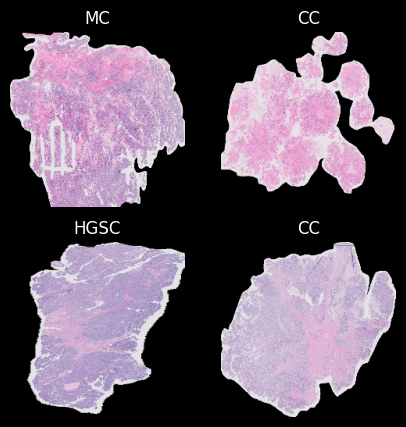

In [9]:
# import matplotlib.pyplot as plt 
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(4):
    # print(class_names[labels[i]])
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

## Transfert learning 

### Features extraction 

pre-trained models list
DenseNet169
vgg19
ResNet101
ResNet50V2


In [11]:
# # create the base pre-trained model
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    # input_tensor=None,
    # input_shape=None,
    # pooling=None,
    classes=5,
    classifier_activation="softmax",
)

In [12]:
base_model.trainable = False

In [13]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input 

In [14]:
train_batches = train_dataset.cardinality().numpy()
# val_batches = validation_dataset.cardinality().numpy()

print(f"num batches : {train_batches}")

num batches : 1


In [15]:
# extract features from train_dataset
# extract images 
train_image,labels_train= next(iter(train_dataset))
batch0 = preprocess_input(train_image)

# extract features 
batch0= base_model.predict(batch0)
batch0_shape = batch0.shape

# reshape features 
features_reshaped_train = np.reshape(batch0,(-1,batch0_shape[1]*batch0_shape[2]*batch0_shape[3]))

23/23 [==============================] - 115s 5s/step


In [16]:
# create class weights

weights = skl.utils.class_weight.compute_class_weight('balanced',
                                                      classes = [i for i in range(5)],
                                                    #    y=[class_names[id] for id in labels_train.numpy()] )
                                                       y=labels_train.numpy()
                                                    )
class_weights = {i: round(weights[i],2) for i in range(5) }
class_weights


{0: 1.07, 1: 0.9, 2: 0.46, 3: 2.56, 4: 2.47}

In [17]:
# create models dict
Models = dict()
Scores = dict()


In [18]:
# fit and score function 
from sklearn.model_selection import cross_val_score
def fit_and_score(model,X_train,y_train,X_test,y_test):
    fit = model.fit(X_train,y_train)
    score = 100*round(fit.score(X_test,y_test),3)
    #score = cross_val_score(fit, X_test, y_test, scoring='accuracy', cv=5)
    return(score)

In [19]:

# split data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# y = [class_names[id] for id in labels_train.numpy()]  

X_train, X_test, y_train, y_test = train_test_split(features_reshaped_train,
                                                    labels_train.numpy(),
                                                    # y,
                                                    test_size=0.2, 
                                                    random_state=2020)

In [20]:
#imports scikit-learn models 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

In [21]:
# Models dict
# glm
Models["glm"] = LogisticRegression(max_iter = 500,
                                   class_weight=class_weights,
                                   random_state=0)
# # # logr reg CV
# Models["logRegCV"] = LogisticRegressionCV(cv = 5,max_iter = 500,
#                                           class_weight=class_weights,
#                                           random_state=0)
# ridge classifier 
# Models["ridgeClf"]= linear_model.RidgeClassifier(alpha=.5,max_iter = 500,
#                                                  class_weight=class_weights,random_state=2020)
# ridge classifier CV
# Models["ridgeCV"]= linear_model.RidgeClassifierCV(alphas = [0.1,0.2,0.3,0.4,0.5,0.6],
                                                # cv = 5,class_weight=class_weights)

# Decision tree
Models["DT"] = tree.DecisionTreeClassifier(random_state=2020, 
                                            class_weight=class_weights)

# Ensemble learning 
# Gradient boosting classifier 
# Models["GBTclf"] = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#         max_depth=1, random_state=0)

# random Forest
Models["Rfclf"]= RandomForestClassifier(n_estimators=10,
                                        min_samples_split= 100,
                                        class_weight=class_weights)

Models["bagging"] = BaggingClassifier(Models["Rfclf"],max_samples=0.5, max_features=0.7,
                                      bootstrap=True,
                                      bootstrap_features=True,
                                      random_state=0)

# voting classifier 
Models["votingClf_hard"] =  VotingClassifier(
estimators=[('lr', Models["glm"]), 
            ('rf', Models["Rfclf"]), 
            ('DT', Models["DT"]),
            # ('LogRegCV',Models["logRegCV"]),
            ('bagging',Models['bagging'])
            ],
voting='hard')


In [22]:
#fit and score models 
for model_keys in Models:
    print(model_keys)
    model = Models[model_keys] 
    Scores[model_keys] = fit_and_score(model,X_train,y_train,X_test,y_test)

glm


DT
Rfclf
bagging
votingClf_hard


In [23]:
# yield scores df
scores_df = pd.DataFrame(Scores.values(),
             index = Models.keys(),
             columns = ["scores"]
            #  columns = [f"scoreCV{d}" for d in range(1,6)]
             )
print((scores_df.sort_values(by = "scores",ascending=False)
.head(4)
    )
)

                scores
glm               52.8
votingClf_hard    36.1
Rfclf             33.3
bagging           31.9


In [24]:
# print("pred:",fit.predict(X_test).tolist())
# print("true:",[y_test[i] for i in range(len(y_test))])

In [25]:
# test data 
# test_csv = pd.read_csv("test.csv")

In [26]:
# test_csv

In [27]:
os.system('say "end of features extraction" ') 

0

### training on top of pre-trained model

In [28]:
# create data sets
# train_dir = './train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.
Using 573 files for training.


In [29]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset = "validation",
                                                                 validation_split = 0.2,
                                                            seed = 123)

Found 716 files belonging to 5 classes.
Using 143 files for validation.


In [30]:
# test dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [31]:
# Configure datasets for perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [32]:
#  augmentation layers
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
tf.keras.layers.RandomFlip('vertical'),
tf.keras.layers.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.RandomRotation(factor=0.2),
tf.keras.layers.RandomBrightness(0.2),
#new added layers
tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

In [33]:
# add a global spatial average pooling layer
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu',kernel_regularizer = "l2")(x)
x = tf.keras.layers.Dropout(0.3)(x)
predictions = Dense(5, activation='softmax')(x)


In [34]:
# this is the model we will train
model = Model(inputs= inputs, outputs=predictions)

In [35]:
len(model.trainable_variables)

4

In [36]:
# compile model 
base_learning_rate = 2e-6
model.compile(tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
# optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics="accuracy")

# tensorboard 
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [37]:
initial_epochs =10

loss0,accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 19s 2s/step - loss: 15.6682 - accuracy: 0.1899


In [38]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False


In [39]:
# train the model on the new data for a few epochs
history = model.fit(train_dataset,
          epochs=initial_epochs,
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)


Epoch 1/10
18/18 [==============================] - 124s 5s/step - loss: 15.5654 - accuracy: 0.1571 - val_loss: 15.5751 - val_accuracy: 0.1392
Epoch 2/10
18/18 [==============================] - 113s 5s/step - loss: 15.4893 - accuracy: 0.1588 - val_loss: 15.4555 - val_accuracy: 0.2025
Epoch 3/10
18/18 [==============================] - 119s 6s/step - loss: 15.4294 - accuracy: 0.1588 - val_loss: 15.3858 - val_accuracy: 0.2025
Epoch 4/10
18/18 [==============================] - 122s 6s/step - loss: 15.3877 - accuracy: 0.1571 - val_loss: 15.3487 - val_accuracy: 0.1772
Epoch 5/10
18/18 [==============================] - 117s 5s/step - loss: 15.3545 - accuracy: 0.1920 - val_loss: 15.2593 - val_accuracy: 0.1899
Epoch 6/10
18/18 [==============================] - 117s 6s/step - loss: 15.2754 - accuracy: 0.1606 - val_loss: 15.2517 - val_accuracy: 0.1519
Epoch 7/10
18/18 [==============================] - 146s 7s/step - loss: 15.2377 - accuracy: 0.1885 - val_loss: 15.1839 - val_accuracy: 0.1392

##### learning curve 

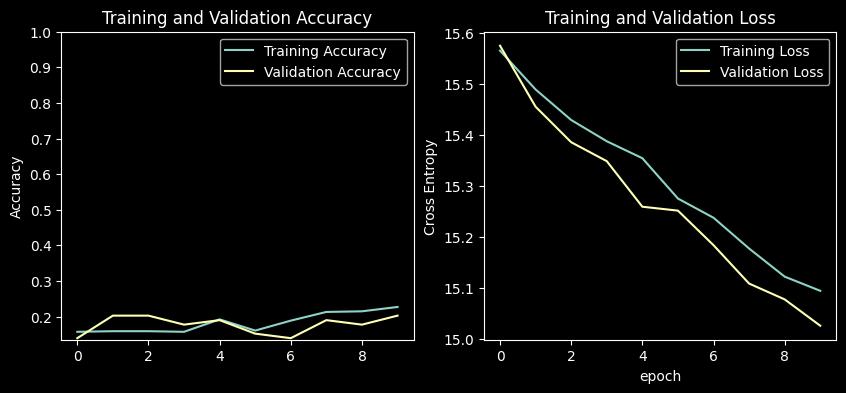

In [40]:
# plot training and validation metrics
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:

os.system('say "end transfert learning" ')

0

#### Fine-tuning 

In [42]:
# un-freeze model weights
base_model.trainable = True

In [43]:
n_layers = len(base_model.layers)
print(n_layers)


190


In [44]:
n_layers*8//10

152

In [45]:
n_layers - n_layers*8//10

38

In [46]:

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
n_trainable_layers = n_layers*9//10
for layer in model.layers[:n_trainable_layers]:
   layer.trainable = False
for layer in model.layers[n_trainable_layers:]:
   layer.trainable = True


#### Recompile model

In [47]:
# from tensorflow.keras.optimizers import SGD
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate/10), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = "accuracy")

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
fine_tune_epochs = 2*initial_epochs
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
          epochs=total_epochs,
          initial_epoch = history.epoch[-1],
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)

Epoch 10/30


18/18 [==============================] - 134s 6s/step - loss: 15.0537 - accuracy: 0.2199 - val_loss: 15.0429 - val_accuracy: 0.2152
Epoch 11/30
18/18 [==============================] - 119s 6s/step - loss: 15.0624 - accuracy: 0.2408 - val_loss: 15.0233 - val_accuracy: 0.1519
Epoch 12/30
18/18 [==============================] - 119s 6s/step - loss: 15.0702 - accuracy: 0.2164 - val_loss: 15.0153 - val_accuracy: 0.2405
Epoch 13/30
18/18 [==============================] - 150s 7s/step - loss: 15.0498 - accuracy: 0.2182 - val_loss: 15.0036 - val_accuracy: 0.2025
Epoch 14/30
18/18 [==============================] - 129s 6s/step - loss: 15.0588 - accuracy: 0.2408 - val_loss: 15.0051 - val_accuracy: 0.1646
Epoch 15/30
18/18 [==============================] - 123s 6s/step - loss: 15.0851 - accuracy: 0.1902 - val_loss: 14.9877 - val_accuracy: 0.2152
Epoch 16/30
18/18 [==============================] - 150s 7s/step - loss: 15.0668 - accuracy: 0.2251 - val_loss: 15.0004 - val_accuracy: 0.2278
Epoc

#### Fine-tuning leanrning curve 

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

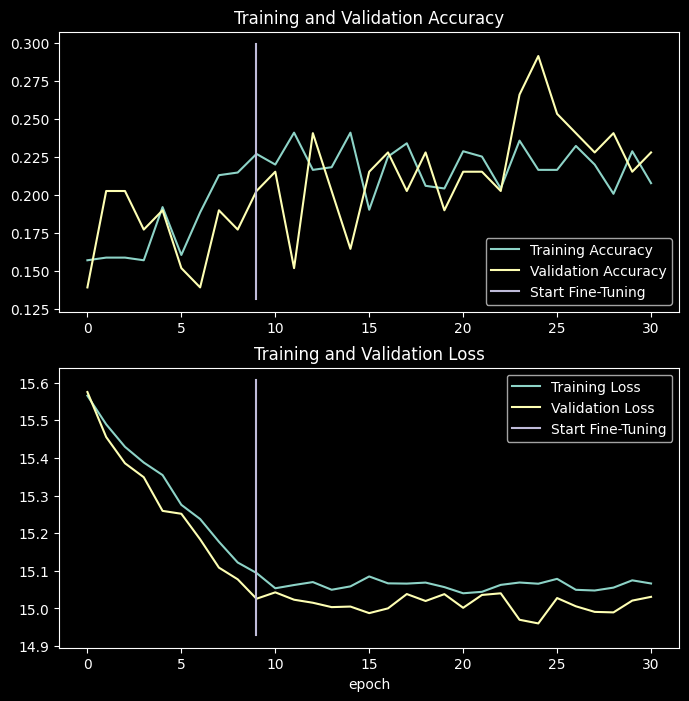

In [49]:
# plot training and validation metrics
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [51]:
test_image_batch,test_label_batch = next(iter(test_dataset))

In [52]:
predicted_batch = model.predict(test_image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1,)
test_labels = [class_names[id] for id in test_label_batch]
predicted_labels = [class_names[id] for id in predicted_id]
print("test labels:",test_labels)
print("pred labels:",predicted_labels)

2023-12-06 18:52:17.683061: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model/sequential/random_crop/cond/branch_executed/_10


1/1 [==============================] - 6s 6s/step
test labels: ['HGSC', 'EC', 'CC', 'HGSC', 'MC', 'EC', 'MC', 'HGSC', 'EC', 'CC', 'EC', 'HGSC', 'EC', 'EC', 'HGSC', 'HGSC', 'HGSC', 'LGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'EC', 'HGSC', 'EC', 'HGSC', 'EC', 'MC', 'EC', 'CC', 'HGSC']
pred labels: ['EC', 'CC', 'HGSC', 'EC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'LGSC', 'EC', 'HGSC', 'HGSC', 'LGSC', 'HGSC', 'CC', 'CC', 'CC', 'CC', 'CC', 'EC', 'CC', 'CC', 'EC', 'CC', 'EC', 'EC', 'CC', 'CC', 'CC', 'CC']



Not quite quite good !!!

## hyper-params tuning : TO DO 

In [53]:
os.system('say "End of fine-tuning"')

0